In [52]:
import pandas as pd
import random
import torch
import re

from matplotlib import pyplot as plt

from transformers import AutoModel, AutoTokenizer, BertTokenizer
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

In [13]:
SEED = 5
random.seed(SEED)
torch.manual_seed(SEED)

In [14]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("cpu와 cuda 중 다음 기기로 학습함:", DEVICE)

cpu와 cuda 중 다음 기기로 학습함: cpu


In [15]:
train = pd.read_csv('./data/train.csv').drop('ID', axis=1)
test = pd.read_csv('./data/test.csv').drop('ID', axis=1)

In [17]:
display(train.head(2), test.head(2))

,first_party,second_party,facts,first_party_winner
0,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1
1,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0


,first_party,second_party,facts
0,Salerno,United States,The 1984 Bail Reform Act allowed the federal c...
1,Milberg Weiss Bershad Hynes and Lerach,"Lexecon, Inc.",Lexecon Inc. was a defendant in a class action...


In [31]:
train['first_party'].replace('[^A-Za-z0-9가-힣]', '', regex=True, inplace=True)
train['second_party'].replace('[^A-Za-z0-9가-힣]', '', regex=True, inplace=True)
train['facts'].replace('[^A-Za-z0-9가-힣]', '', regex=True, inplace=True)

test['first_party'].replace('[^A-Za-z0-9가-힣]', '', regex=True, inplace=True)
test['second_party'].replace('[^A-Za-z0-9가-힣]', '', regex=True, inplace=True)
test['facts'].replace('[^A-Za-z0-9가-힣]', '', regex=True, inplace=True)

In [33]:
display(train.head(2), test.head(2))

,first_party,second_party,facts,first_party_winner
0,PhilAStAmant,HermanAThompson,OnJune271962PhilStAmantacandidateforpublicoffi...,1
1,StephenDuncan,LawrenceOwens,RamonNelsonwasridinghisbikewhenhesufferedaleth...,0


,first_party,second_party,facts
0,Salerno,UnitedStates,The1984BailReformActallowedthefederalcourtstod...
1,MilbergWeissBershadHynesandLerach,LexeconInc,LexeconIncwasadefendantinaclassactionlawsuitUn...


In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2478 entries, 0 to 2477
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   first_party         2478 non-null   object
 1   second_party        2478 non-null   object
 2   facts               2478 non-null   object
 3   first_party_winner  2478 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 77.6+ KB


In [35]:
train.describe(include='all')

,first_party,second_party,facts,first_party_winner
count,2478,2478,2478,2478.000000
unique,2106,1970,2478,NaN
top,UnitedStates,UnitedStates,OnJune271962PhilStAmantacandidateforpublicoffi...,NaN
freq,154,240,1,NaN
mean,NaN,NaN,NaN,0.665456
std,NaN,NaN,NaN,0.471926
min,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,1.000000


In [36]:
train.duplicated().sum()

0

학습 문장 최대 길이 : 4726
학습 문장의 평균 길이 : 908.5504439063761


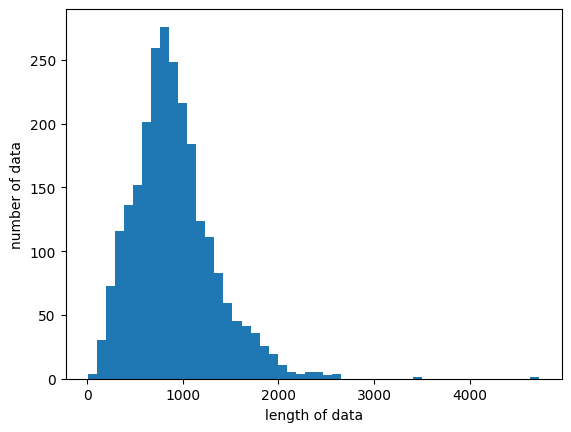

In [37]:
#학습 리뷰 길이조사
print('학습 문장 최대 길이 :',max(len(l) for l in train['facts']))
print('학습 문장의 평균 길이 :',sum(map(len, train['facts']))/len(train['facts']))

plt.hist([len(s) for s in train['facts']], bins=50)
plt.xlabel('length of data')
plt.ylabel('number of data')
plt.show()

학습 문장 최대 길이 : 4986
학습 문장의 평균 길이 : 909.016129032258


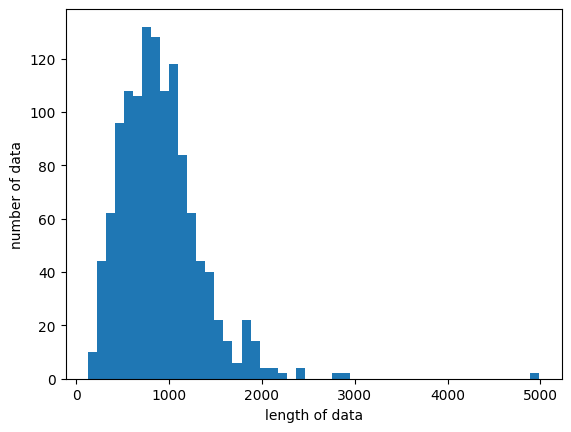

In [40]:
#학습 리뷰 길이조사
print('학습 문장 최대 길이 :',max(len(l) for l in test['facts']))
print('학습 문장의 평균 길이 :',sum(map(len, test['facts']))/len(test['facts']))

plt.hist([len(s) for s in test['facts']], bins=50)
plt.xlabel('length of data')
plt.ylabel('number of data')
plt.show()

In [41]:
MODEL_NAME = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

c:\jhs_pr\jhs_tf\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\SAFEZONE_M_09\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [42]:
tokenized_train_sentences = tokenizer(
    list(train['facts']),
    return_tensors="pt",
    padding=True,
    truncation=True,
    add_special_tokens=True,
    )

print(tokenized_train_sentences[0])
print(tokenized_train_sentences[0].tokens)
print(tokenized_train_sentences[0].ids)
print(tokenized_train_sentences[0].attention_mask)

Encoding(num_tokens=31, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
['[CLS]', '[UNK]', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
[101, 100, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [44]:
tokenized_test_sentences = tokenizer(
    list(test['facts']),
    return_tensors="pt",
    padding=True,
    truncation=True,
    add_special_tokens=True,
    )

print(tokenized_test_sentences[0])
print(tokenized_test_sentences[0].tokens)
print(tokenized_test_sentences[0].ids)
print(tokenized_test_sentences[0].attention_mask)

Encoding(num_tokens=3, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
['[CLS]', '[UNK]', '[SEP]']
[101, 100, 102]
[1, 1, 1]


In [48]:
train[train.columns[-1]].values

array([1, 0, 1, ..., 0, 0, 0], dtype=int64)

In [50]:
train_label = train['first_party_winner'].values

print(train_label)

[1 0 1 ... 0 0 0]


In [49]:
class SingleSentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [51]:
train_dataset = SingleSentDataset(tokenized_train_sentences, train_label)

In [55]:
# model = BertForSequenceClassification.from_pretrained(MODEL_NAME)
# model.to(device)
# model.train()

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# optim = AdamW(model.parameters(), lr=5e-5)

# for epoch in range(3):
#     for batch in train_loader:
#         optim.zero_grad()
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         labels = batch['labels'].to(device)
#         outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs[0]
#         loss.backward()
#         optim.step()

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.20.1`: Please run `pip install transformers[torch]` or `pip install accelerate -U`